# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from ml.visualization import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

np.random.seed(0)  # Para mayor determinismo

## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
display(dataset.head())

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


In [3]:
print('Número de Instancias: %.2f' % X.shape[0])
print('Número de Atributos: %.2f' % (X.shape[1]))
print('Instancias de Conjunto de Evaluación (Test): %.2f' % np.trunc(X.shape[0]*0.2))
print('Instancias de Conjunto de Entrenamiento (Training): %.2f' % np.ceil(X.shape[0]*0.8))

Número de Instancias: 1854.00
Número de Atributos: 10.00
Instancias de Conjunto de Evaluación (Test): 370.00
Instancias de Conjunto de Entrenamiento (Training): 1484.00


## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

De acuerdo al análisis previo, realizamos la siguiente **partición de los datos**, luego de aplicar una permutación aleatória:

In [4]:
shuff_data = np.random.permutation(1854)
shuff_train = shuff_data[:1484]
shuff_test = shuff_data[1484:]

In [5]:
X_train = X.iloc[shuff_train,:]
X_test = X.iloc[shuff_test,:]

In [6]:
y_train = y.iloc[shuff_train,]
y_test = y.iloc[shuff_test,]

## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático.

Antes de efectuar la formulación de la hipótesis, realizamos un análisis exploratorio de los datos.

In [7]:
dataset.describe()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.166667,19111.758360,76316.051780,107321.088457,8.900216,0.187702,0.319849,180.300783,1.128910,21.857066,34.573408
std,0.372779,11000.345961,46227.026585,56039.685066,7.552677,0.704882,0.928452,84.838308,1.664555,9.510840,9.308794
min,0.000000,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,0.000000,12000.000000,48984.750000,70787.250000,3.000000,0.000000,0.000000,116.970718,0.000000,16.000000,29.427210
50%,0.000000,17000.000000,67201.000000,94198.000000,7.000000,0.000000,0.000000,174.967815,1.000000,21.000000,35.363407
75%,0.000000,23900.000000,93731.500000,122976.250000,13.000000,0.000000,0.000000,232.261800,2.000000,27.000000,39.357987
max,1.000000,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


Las variables explicativas no deben estar muy correlacionadas entre ellas, ya que la variabilidad de una y otra estarán explicando la misma parte de variabilidad de la variable dependiente.

In [8]:
df_corr = dataset.corr() # Pearson, Standard Correlation Coefficient

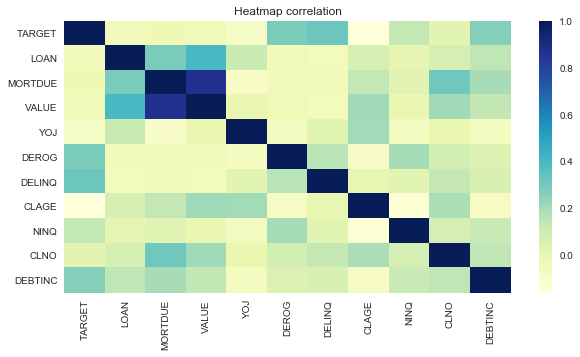

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(df_corr, cmap="YlGnBu") # Displaying the Heatmap
sns.set(font_scale=1,style='white')

plt.title('Heatmap correlation')
plt.show()

En este caso, `VALUE` y `MORTDUE` están bastante correlacionadas.

Seguimos explorando de a pares de variables, gráficamente:

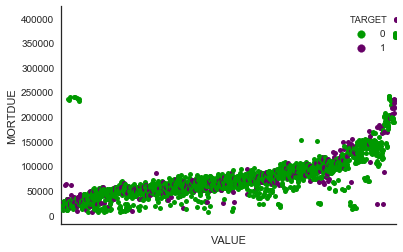

In [20]:
graph = sns.stripplot(x="VALUE", y="MORTDUE", hue="TARGET", data=dataset, jitter=True, palette = ['#009900', '#660066'], dodge=True)
graph.set_xticklabels([])

sns.despine()

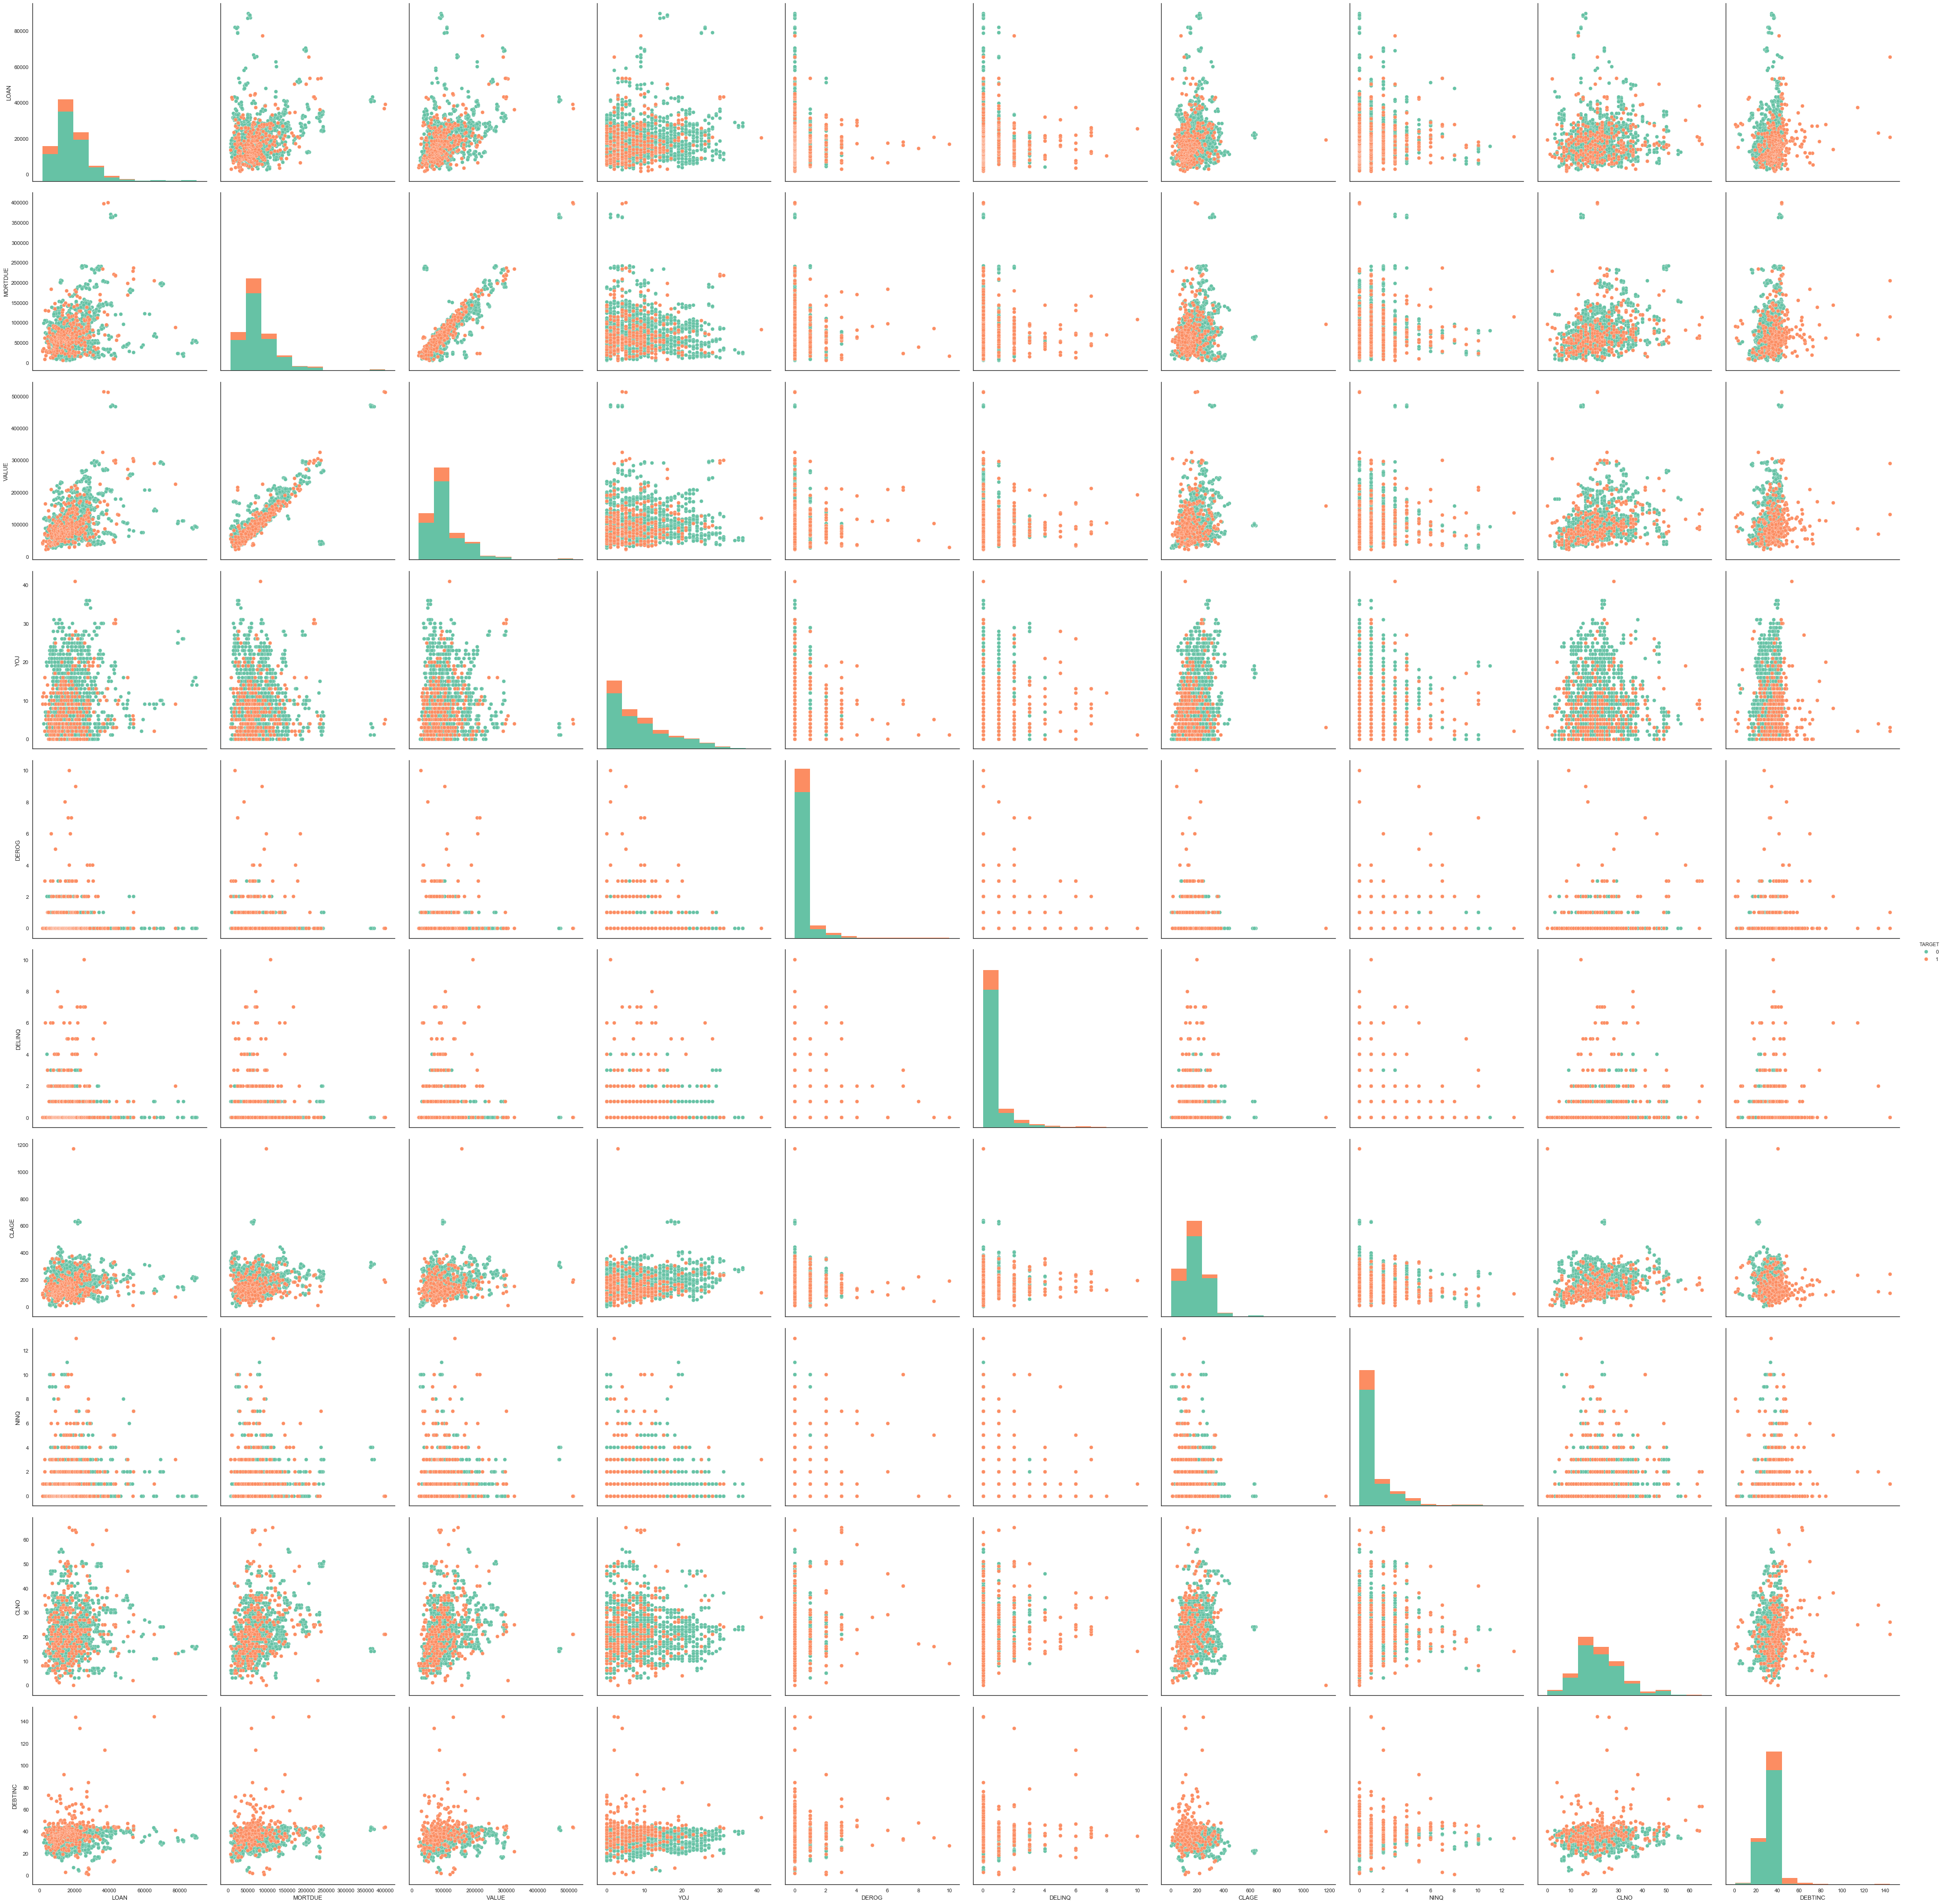

In [21]:
sns.pairplot(vars=X.columns, data=dataset, hue="TARGET", palette= "Set2", size=5)

In [12]:
y.sum()/y.count()

0.16666666666666666

In [13]:
(y==0).sum()

1545

In [14]:
X.columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC'],
      dtype='object')

Recuerden que los pasos para elegir un modelo son:

### Selección de hipótesis

En este caso, lo que se pretende predecir es la probabilidad de que un cliente de un banco que acceda a una hipoteca entre en default. Es decir, $P(y=1 | X,w)$. Dado que $y$ es una variable categórica, estamos ante un problema de clasificación. De acuerdo a la estructura de los datos, podemos suponer que el *default* de clientes es una variable aleatoria que se distribuye Bernoulli. Luego, el modeleo elegido es el logístico:

$h_w(x) = \dfrac{1}{1+exp^{(-w^Tx)}}$

En donde $x =$ [LOAN, MORTDUE, VALUE, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC] y $w$ son los parámetros a estimar.

En este caso, utilizaremos una regresión logística para abordar el problema de clasificación, con una función de predicción $h_w(x)$ para aproximar la probabilidad buscada.

### Selección de regularizador

Además, se utilizará como regularizadora de la función de costos la norma 2 (l2), con un factor de regularización $\lambda$.

### Selección de función de costo

La función de costo será la de costo logístico, con regularización:

$L(w) = -\sum_{i=1}^{N} [y_i log(h_w(x_i)) + (1-y_i) log(1-h_w(x_i))] + \lambda |w|^2_2$

### Justificación de las selecciones

Se optó por incluir el término regularizador para tratar de evitar una excesiva complejidad en el modelo, mientras que la función de costo logística fue elegida porque penaliza más a aquellas predicciones mientras más se alejan de su verdadera etiqueta.

## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

# Exploración de Hiperparámetros para Función de Costo log con Penalización l1

Mejor conjunto de parámetros:
{'C': 5, 'max_iter': 10000, 'tol': 0.005}

Puntajes de la grilla:

Exactitud: 0.791 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 1000, 'tol': 0.005}
Exactitud: 0.790 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 1000, 'tol': 0.002}
Exactitud: 0.789 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 1000, 'tol': 0.001}
Exactitud: 0.788 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 1000, 'tol': 0.0001}
Exactitud: 0.791 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 5000, 'tol': 0.005}
Exactitud: 0.791 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 5000, 'tol': 0.002}
Exactitud: 0.789 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 5000, 'tol': 0.001}
Exactitud: 0.788 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 5000, 'tol': 0.0001}
Exactitud: 0.791 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 10000, 'tol': 0.005}
E

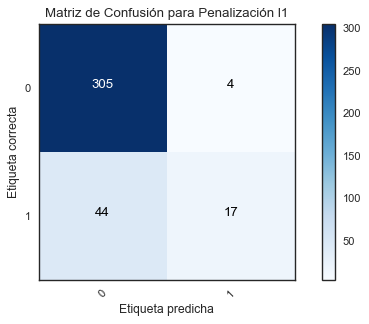

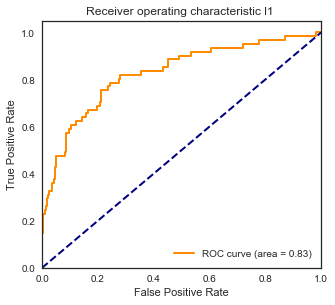

# Exploración de Hiperparámetros para Función de Costo log con Penalización l2

Mejor conjunto de parámetros:
{'C': 10, 'max_iter': 1000, 'tol': 0.0001}

Puntajes de la grilla:

Exactitud: 0.547 (+/-0.001) para los parámetros {'C': 0.5, 'max_iter': 1000, 'tol': 0.005}
Exactitud: 0.547 (+/-0.001) para los parámetros {'C': 0.5, 'max_iter': 1000, 'tol': 0.002}
Exactitud: 0.626 (+/-0.001) para los parámetros {'C': 0.5, 'max_iter': 1000, 'tol': 0.001}
Exactitud: 0.666 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 1000, 'tol': 0.0001}
Exactitud: 0.547 (+/-0.001) para los parámetros {'C': 0.5, 'max_iter': 5000, 'tol': 0.005}
Exactitud: 0.547 (+/-0.001) para los parámetros {'C': 0.5, 'max_iter': 5000, 'tol': 0.002}
Exactitud: 0.626 (+/-0.001) para los parámetros {'C': 0.5, 'max_iter': 5000, 'tol': 0.001}
Exactitud: 0.666 (+/-0.002) para los parámetros {'C': 0.5, 'max_iter': 5000, 'tol': 0.0001}
Exactitud: 0.547 (+/-0.001) para los parámetros {'C': 0.5, 'max_iter': 10000, 'tol': 0.005}


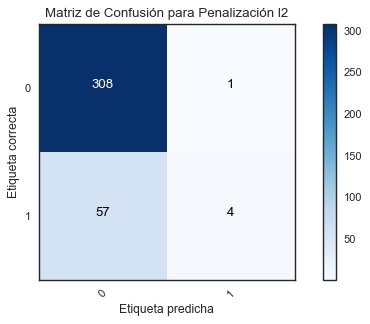

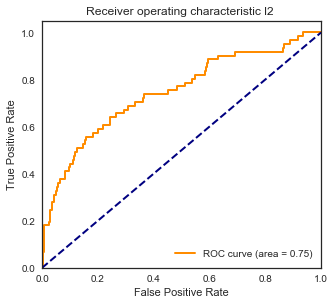

In [15]:
for i,penalty in enumerate(('l1','l2'), start=1):
    loss = 'log'
    exploring_params = {
        'C': [0.5, 1, 2, 5, 10, 20, 100, 200], # Inversa del coeficiente de regularización
        'max_iter': [1000, 5000, 10000],  # Cantidad de iteraciones
        'tol': [0.005, 0.002, 0.001, 0.0001]  # Precisión del algoritmo
    }
    m = LogisticRegression(penalty=penalty, multi_class='ovr')
    n_cross_val = 5
    scoring = 'roc_auc'
    model = GridSearchCV(m, exploring_params, cv=n_cross_val, scoring=scoring) #DUDA: TENGO QUE INCLUIR BIAS EN X?
    model.fit(X_train, y_train)
    print("# Exploración de Hiperparámetros para Función de Costo %s con Penalización %s" % (loss, penalty), end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")
    
    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
        
    print()
    
    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("================================================", end="\n\n")
    
    plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
    
    plt.subplot(1, 2, i)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0,1], title="Matriz de Confusión para Penalización %s" % penalty)
    
    y_score = model.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(5, 10))

    plt.subplot(2, 1, i)
        
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %s ' %penalty)
    plt.legend(loc="lower right")
    plt.show()

## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

Exactitud para entrenamiento: 0.87
Exactitud para validación: 0.87

Reporte de Clasificación Para el Conjunto de Entrenamiento:

             precision    recall  f1-score   support

          0       0.88      0.98      0.93      1236
          1       0.81      0.32      0.46       248

avg / total       0.87      0.87      0.85      1484



Reporte de Clasificación Para el Conjunto de Validación:

             precision    recall  f1-score   support

          0       0.87      0.99      0.93       309
          1       0.81      0.28      0.41        61

avg / total       0.86      0.87      0.84       370




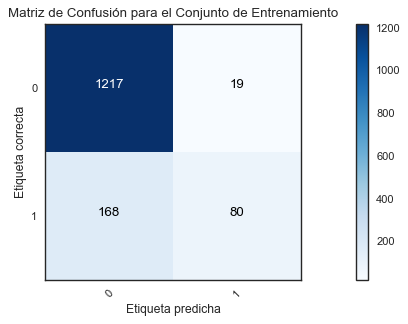

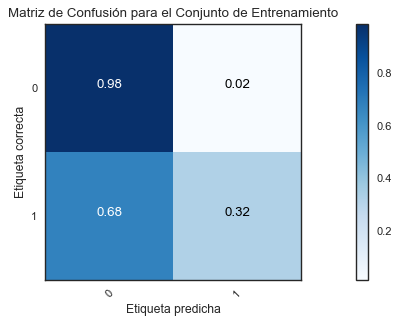

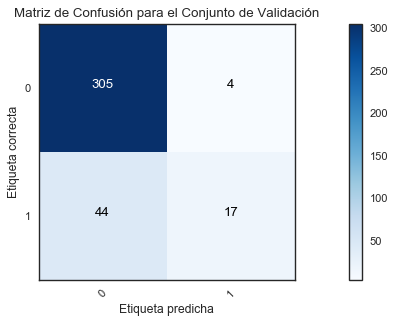

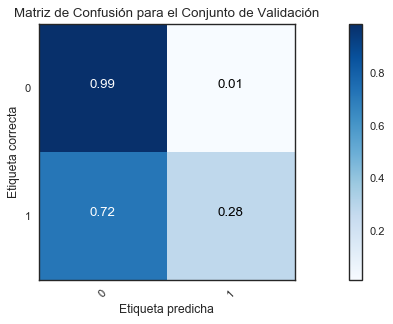

In [23]:
penalty = 'l1' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
C = 5 # Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.
max_iter = 10000 # Cantidad máxima de iteraciones del algoritmo.
tol = 0.005 # Precisión del algoritmo (error mínimo entre una iteración y la siguiente).

model = LogisticRegression(penalty=penalty, C=C , max_iter=max_iter, tol=tol, multi_class='ovr')
model.fit(X_train, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train)))
print('Exactitud para validación: %.2f' % accuracy_score(y_test, model.predict(X_test)))

print("================================================", end="\n\n")

print("Reporte de Clasificación Para el Conjunto de Entrenamiento:", end="\n\n")
y_true, y_pred = y_train, model.predict(X_train)
print(classification_report(y_true, y_pred), end="\n\n")

plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0,1], title="Matriz de Confusión para el Conjunto de Entrenamiento")
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0,1], normalize = True, title="Matriz de Confusión para el Conjunto de Entrenamiento")

print("================================================", end="\n\n")

print("Reporte de Clasificación Para el Conjunto de Validación:", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0,1], title="Matriz de Confusión para el Conjunto de Validación")
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0,1], normalize = True, title="Matriz de Confusión para el Conjunto de Validación")

Vemos que la exactitud es similar en ambos conjuntos, el de entrenamiento y el de validación. Sin embargo, la utilidad del modelo es discutible, ya que predice correctamente un 28% de los clientes que efectivamente defaultean, en el conjunto de validación.

## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

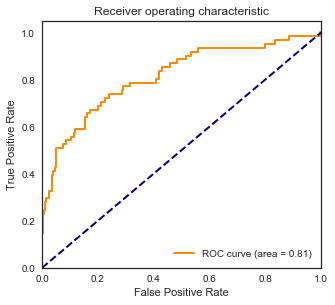

In [17]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize=(5, 10))

plt.subplot(2, 1, i)
        
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()